In [11]:
import numpy as np
import pandas as pd

sheet_ID = '1vxUH72hoDYbEdTOMYvr0XnmnDDm6AewWVzzFzn6c_jE'
df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_ID}/export?format=csv")

In [7]:
#df.info() # pas de probleme de type d objet, pas de colonne inutile
#df.duplicated().sum() # pas de duplicated
df.isna().sum() # on a des Nan


,0
Species,4
Weight,0
Length1,2
Length2,2
Length3,9
Height,3
Width,2


Modification apporter au dataset pour le clean :

In [12]:
# on retire tout les Nan de notre dataset
df['Species'].ffill(inplace=True)
df['Length1'].fillna(df['Length1'].mean(), inplace = True)
df['Length2'].fillna(df['Length2'].mean(), inplace = True)
df['Length3'].fillna(df['Length3'].mean(), inplace = True)
df['Height'].fillna(df['Height'].mean(), inplace = True)
df['Width'].fillna(df['Width'].mean(), inplace = True)


/tmp/ipython-input-2962308894.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Species'].ffill(inplace=True)
/tmp/ipython-input-2962308894.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

In [13]:
df.isna().sum()

,0
Species,0
Weight,0
Length1,0
Length2,0
Length3,0
Height,0
Width,0


Split

In [14]:
from sklearn.model_selection import train_test_split
#va nous permettre de split notre data set

X = df.drop(columns='Weight') #features
y = df['Weight'] #ttarget (colums predicted)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.3) #test_size=.3 => 70-30%
# par defaut le split se fait 70%-30%

Modele

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# import linear regression model
from sklearn.linear_model import LinearRegression
# import regression metrics needed from sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [17]:
# Define the custom functions for regressoin evaluation
def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):
    # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Use explicit square root calculation for RMSE
    r_squared = r2_score(y_true, y_pred)

    if verbose:
        # Print Result with Label and Header
        header = "-" * 60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")

    if output_dict:
        metrics = {'Label': label, 'MAE': mae,
                   'MSE': mse, 'RMSE': rmse, 'R^2': r_squared}
        return metrics



def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [20]:
# Get the correlation matrix, sort by correlations with "Weight"
corr = df.drop(columns='Species').corr().sort_values(by='Weight', ascending=False).round(2)
corr

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.00,0.92,0.88,0.86,0.72,0.89
Length1,0.92,1.00,0.95,0.92,0.63,0.87
Width,0.89,0.87,0.87,0.83,0.78,1.00
Length2,0.88,0.95,1.00,0.95,0.65,0.87
Length3,0.86,0.92,0.95,1.00,0.69,0.83
Height,0.72,0.63,0.65,0.69,1.00,0.78


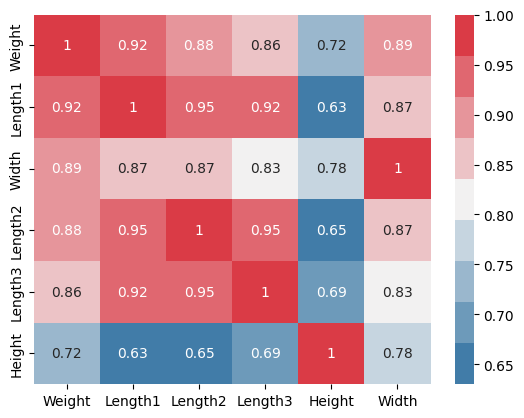

In [21]:
# You can use a heat map to make it easier (in theory) to read the correlation matrix.
ax = sns.heatmap(corr,
            cmap = sns.diverging_palette(240, 10, n=9), annot = True);

Toute nos valeurs sont corrélés avec 'Weight' et nous faisons de la Regression.
On va donc utiliser le modèle Linear Regression

In [22]:
# Approach 1) finding correlations with an absolute value >.5
filt_abs_corr = corr['Weight'].abs() > .5
corr.loc[filt_abs_corr, "Weight"]

,Weight
Weight,1.00
Length1,0.92
Width,0.89
Length2,0.88
Length3,0.86
Height,0.72


In [23]:
# Approach 2) OR Using the sorted correlation dataframe to get top 3 correlated features
corr['Weight'].abs().sort_values(ascending=False).head(4)

,Weight
Weight,1.00
Length1,0.92
Width,0.89
Length2,0.88


In [24]:
# getting the columns requested in the task
df = df.loc[:, ['Length1', 'Length2','Length3', 'Weight']]
df.head()

,Length1,Length2,Length3,Weight
0,23.2,25.4,30.0,242.0
1,24.0,26.3,31.2,290.0
2,23.9,26.5,31.1,340.0
3,26.3,29.0,33.5,363.0
4,26.5,29.0,34.0,430.0


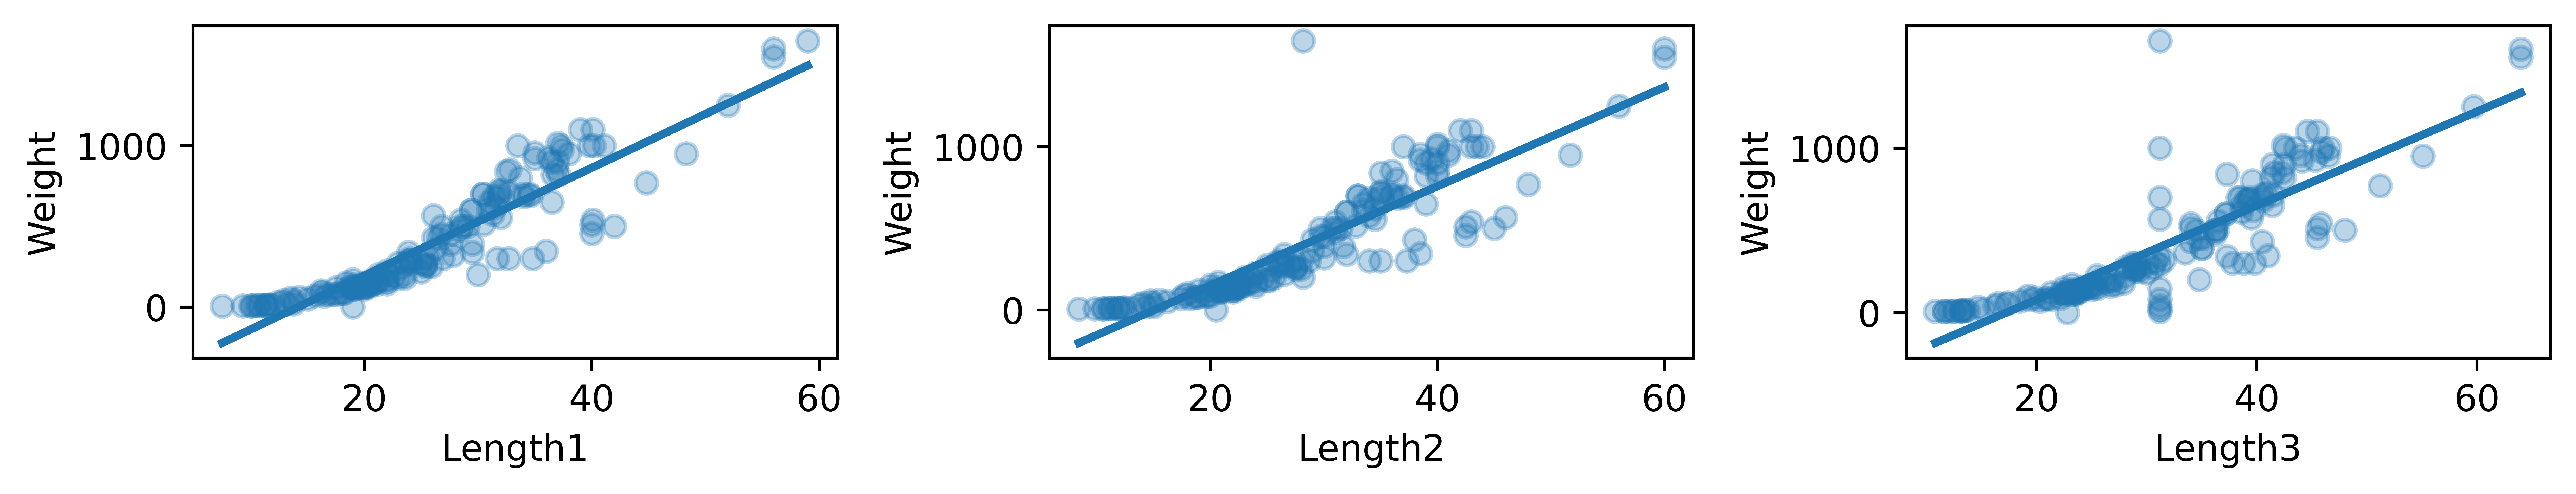

In [25]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=1000)
sns.regplot(x='Length1', y='Weight', data=df, ci=None, ax = axes[0], scatter_kws={'alpha':0.3});
sns.regplot(x='Length2', y='Weight', data=df, ci=None, ax = axes[1], scatter_kws={'alpha':0.3});
sns.regplot(x='Length3', y='Weight', data=df, ci=None, ax = axes[2], scatter_kws={'alpha':0.3});
fig.tight_layout()